# Candidate Test 2022 Analysis Part 2

This exercise focuses on the candidate tests from two television networks: DR and TV2. Data from both tests have been given on a scale of five responses (-2, -1, 0, 1, 2). Consider normalizing the data or performing similar scaling transformations as needed.

---

There are 6 datasets included in this exercise:

- `alldata.xlsx`: Contains responses from both TV stations.
- `drdata.xlsx`: Contains responses from DR.
- `drq.xlsx`: Contains questions from DR.
- `tv2data.xlsx`: Contains responses from TV2.
- `tv2q.xlsx`: Contains questions from TV2.
- `electeddata.xlsx`: Contains responses from both TV stations for candidates who were elected to the parliament. Note that 9 members are missing; 7 of them didn't take any of the tests. Additionally, some notable figures like Mette F. and Lars Løkke did not participate in any of the tests.

---

It's entirely up to you how you approach this data, but at a *minimum*, your analysis should include:

- An analysis/description of which questions are most crucial concerning their placement on the axes.
- Average positions of parties concerning each question, preferably with accompanying plots of each (or selected) question.
- A clustering analysis where you attempt various cluster numbers, which would correspond to different parties. Discuss whether there is room for more clusters/parties or if a reduction is needed. Make sure you cover: **K-Means, Hierarchical clustering, and DBSCAN.**
- An overview of the political landscape of the elected candidates, highlighting which members agree or disagree the most and which parties or party members have significant disagreements.
- Feel free to explore further and remember that preprocessing, methodology, and evaluation metrics are not mentioned explicitly, but are implicitly assumed.

---

The following parties are represented:

| Party letter | Party name | Party name (English) | Political position |
| :-: | :-: | :-: | :-: |
| A | Socialdemokratiet | Social Democrats | Centre-left |
| V | Venstre | Danish Liberal Party | Centre-right |
| M | Moderaterne | Moderates | Centre-right |
| F | Socialistisk Folkeparti | Socialist People's Party | Left-wing |
| D | Danmarksdemokraterne | Denmark Democrats | Right-wing |
| I | Liberal Alliance | Liberal Alliance | Right-wing |
| C | Konservative | Conservative People's Party | Right-wing |
| Æ | Enhedslisten | Red-Green Alliance | Far-left |
| B | Radikale Venstre | Social Liberal Party | Centre-left |
| D | Nye Borgerlige | New Right | Far-right |
| Z | Alternativet | The Alternative | Centre-left |
| O | Dansk Folkeparti | Danish People's Party | Far-right |
| G | Frie Grønne | Free Greens | Centre-left |
| K | Kristendemokraterne | Christian Democrats | Centre-right |

Below you can see the results and the colors chosen to represent the parties. Use these colors in your analysis above.

![Alt text](image-1.png)


Others have undertaken similar analyses. You can draw inspiration from the following (use Google tranlsate if your Danish is rusty):

- [Analysis of where individual candidates stand relative to each other and their parties](https://v2022.dumdata.dk/)
- [Candidate Test 2022 – A deep dive into the data](https://kwedel.github.io/kandidattest2022/)
- [The Political Landscape 2019](https://kwedel.github.io/kandidattest2019/)



# Example Approach

### 1. Load all data

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

alldata = pd.read_excel('alldata.xlsx')
drdata = pd.read_excel('drdata.xlsx')
drq = pd.read_excel('drq.xlsx')
tv2data = pd.read_excel('tv2data.xlsx')
tv2q = pd.read_excel('tv2q.xlsx')
electeddata = pd.read_excel('electeddata.xlsx')

### 2. Check columns of all data

In [11]:
print(alldata.columns)
print(drq.columns)
print(tv2q.columns)

Index(['530', '531', '533', '534', '535', '537', '538', '540', '541', '543',
       '544', '545', '546', '547', '548', '550', '551', '552', '553', '555',
       '556', '557', '559', '561', '563', 'navn', 'parti', '1a', '1b', '2a',
       '2b', '3a', '3b', '4a', '4b', '5a', '5b', '6a', '6b', '7a', '7b', '8a',
       '8b', '9a', '9b', '10a', '10b', '11a', '11b', '12a', '12b', 'storkreds',
       'alder'],
      dtype='object')
Index(['ID', 'Title', 'Question', 'Info', 'ArgumentFor', 'ArgumentAgainst',
       'WordMerger', 'ID_CandidateQuestionType', 'Rule', 'QuestionListData'],
      dtype='object')
Index(['id', 'type', 'header', 'question', 'depends'], dtype='object')


### 3. Extract and combine questions

In [12]:
# align ids and questions from dr/tv2 for extraction and combination
dr_id_question_series = drq.rename(columns={'ID': 'id', 'Question': 'question'}).set_index('id')['question']
tv2_id_question_series = tv2q.set_index('id')['question']

# concatenate
questions = pd.concat([dr_id_question_series, tv2_id_question_series])
pd.set_option('display.max_rows', None)
print(questions)

id
530                    Danmark skal bruge flere penge på at styrke to...
531                    Der skal indføres en særlig skat på de allerhø...
533                    Kriminalitet begået i udsatte boligområder ska...
534                                 På sigt skal Danmark meldes ud af EU
535                    Det er fornuftigt, at Danmark i de kommende år...
537                    Det er okay, at den økonomiske ulighed stiger,...
538                    Forældres indkomst skal være et af kriterierne...
540                    Det skal være muligt at tjene penge på at driv...
541                    Der skal indføres skat på fortjenesten ved sal...
543                    Det er en god idé, at dagpengesatsen for nyudd...
544                    Transkønnede under 18 år skal have mulighed fo...
545                    Pensionsalderen skal fortsætte med at stige i ...
546                    Danmark skal undersøge muligheden for at udvik...
547                           Der bør dannes en 

### 4. Get translated questions (used Claude.ai)

In [13]:
translated_questions = pd.Series({
    '530': 'Denmark should spend more money on strengthening train and bus services rather than building new motorways',
    '531': 'A special tax should be introduced on the very highest incomes',
    '533': 'Crime committed in vulnerable housing areas should be punished particularly severely',
    '534': 'In the long term, Denmark should leave the EU',
    '535': 'It is sensible that Denmark will spend significantly more money on defense in the coming years',
    '537': 'It is okay for economic inequality to increase as long as Danes generally become richer',
    '538': 'Parents\' income should be one of the criteria for distributing students in high schools',
    '540': 'It should be possible to make a profit from running private kindergartens and nurseries',
    '541': 'Tax should be introduced on profits from home sales',
    '543': 'It is a good idea that the unemployment benefit rate for new graduates has been reduced',
    '544': 'Transgender people under 18 should have the option for legal gender change (changing CPR number)',
    '545': 'The retirement age should continue to rise in line with increasing life expectancy',
    '546': 'Denmark should investigate the possibility of developing nuclear power as an energy source domestically',
    '547': 'A government should be formed across the center',
    '548': 'Money should be allocated to help social benefit recipients when prices rise',
    '550': 'Quotas should be introduced ensuring at least 30 percent women on company boards',
    '551': 'There should be permanent border control between Denmark and Germany',
    '552': 'One should automatically become an organ donor at 18 unless actively opting out',
    '553': 'More education places should be relocated from the big cities',
    '555': 'Asylum seekers should be sent to a country outside the EU - e.g., Rwanda - while their application is processed',
    '556': 'The so-called Arne pension should be abolished',
    '557': 'Wages for employees in classic welfare professions like nurses and educators should be significantly increased',
    '559': 'Denmark should introduce CO2 tax on air travel',
    '561': 'It is a good idea to have nature national parks where large animals are released to live wild',
    '563': 'Young people up to 24 years should have the right to free public psychological help without doctor referral',
    
    # Bornholm specific questions
    'bornholm-1': 'The state should ensure sufficient doctors, nurses, dentists, chiropractors and other healthcare professionals on Bornholm through particularly attractive conditions',
    'bornholm-2': 'The state should ensure that air traffic to and from Bornholm gets status as socially conditioned route and possibility for operational subsidies on par with ferry traffic',
    'bornholm-3': 'More money should be allocated to Defense presence on water, land and in the air on Bornholm',
    'bornholm-4': 'It should be easier to bring in foreign labor to Bornholm',
    'bornholm-5': 'The decision to establish a nature national park on a piece of Almindingen with fenced areas with large animals should be reversed',
    
    # Funen specific questions
    'fyns-1': 'Police should be given more money to combat gang crime in vulnerable housing areas',
    'fyns-2': 'It should be free to cross the Great Belt Bridge at the expense of funding other state infrastructure projects',
    'fyns-3': 'Langeland Municipality should merge with Svendborg Municipality to address economic problems',
    'fyns-4': 'The state should ensure cheaper ferries between Danish islands year-round at the expense of expanding other traffic projects like motorways and railways',
    'fyns-5': 'Even more higher education places should be moved from Odense to other Funen cities',
    
    # Copenhagen outskirts specific questions
    'københavns omegns-1': 'It is more important to invest in sustainable transport like public transit and cycling than expanding motorways such as Hillerød motorway, Frederikssund motorway and Motor Ring 3 and 4',
    'københavns omegns-2': 'Less money should be sent from East to West Denmark in municipal equalization',
    'københavns omegns-3': 'There should be stricter environmental requirements for industry and agriculture near nature areas like streams and lakes to prevent pollution discharge, even if requirements mean extra costs for businesses',
    'københavns omegns-4': 'To reduce congestion, air pollution and CO₂ emissions, road pricing should be introduced so motorists are taxed for driving in Copenhagen and surrounding municipalities Hvidovre, Rødovre, Herlev, Gladsaxe and Gentofte',
    'københavns omegns-5': 'To get more people in the capital to choose bikes over cars, a special travel deduction should be introduced for cyclists so commuters cycling six kilometers or more to work can get a tax deduction',
    
    # Copenhagen specific questions
    'københavns-1': 'Overall it was the right decision to move state workplaces and education outside the capital',
    'københavns-2': 'To reduce congestion, air pollution and CO₂ emissions, road pricing should be introduced so motorists are taxed for driving in Copenhagen',
    'københavns-3': 'Copenhagen should become a trial city for cannabis legalization where state-owned and operated shops can sell cannabis to citizens over 18',
    'københavns-4': 'The artificial peninsula Lynetteholm is a good project',
    'københavns-5': 'The possibility to demolish public housing, sell public housing to private owners or forcibly relocate residents, as for example in Mjølnerparken and Tingbjerg, should be abolished, partly because there is a shortage of affordable housing in Copenhagen',
    
    # North Jutland specific questions 
    'nordjyllands-1': 'It should be easier to get housing loans in sparsely populated areas through state guarantee for part of the home loan',
    'nordjyllands-2': 'Parliament should expand the number of fenced nature national parks in North Jutland where wild horses, cattle and bison are released',
    'nordjyllands-3': 'A third Limfjord connection should be built over Egholm island - even if it potentially affects environment and wildlife on Egholm',
    'nordjyllands-4': 'Study places should be moved from Denmark\'s four largest cities so higher education is spread across the country',
    'nordjyllands-5': 'North Jutland should host new giant wind turbines up to 450 meters as part of a new national test center',
    
    # North Zealand specific questions
    'nordsjællands-1': 'Less money should be sent from East to West Denmark in municipal equalization',
    'nordsjællands-2': 'It is more important to invest in sustainable transport like public transit and cycling than expanding motorways like Hillerød motorway and Frederikssund motorway',
    'nordsjællands-3': 'It is good that Gribskov along with Hellebæk Forest and Teglstrup Hegn will be converted to nature national parks, even though it means the areas will be fenced',
    'nordsjællands-4': 'There should be stricter environmental requirements for industry and agriculture near nature areas like streams and lakes to prevent pollution discharge, even if requirements mean extra costs for businesses',
    'nordsjællands-5': 'More should be done to reduce traffic noise for residents along state roads in North Zealand. The state should finance this more than previously, even if at the expense of other infrastructure projects',
    
    # Zealand specific questions
    'sjællands-1': 'Over 45,000 citizens in Zealand region don\'t have their own permanent family doctor. The state should earmark money for general practitioners instead of spending on building new local hospitals and large central hospitals',
    'sjællands-2': 'It should be made easier to set up wind turbines and solar cells on land - as we saw at Kriegers Flak off Møn where lengthy case processing and complaints from neighbors and nature organizations unnecessarily delay projects',
    'sjællands-3': 'At an old fire school in Korsør, pollution with toxic PFOS/PFAS substances has affected a large local group, and up to 15,000 plots in Denmark are estimated contaminated with these substances. The government/Parliament should allocate more money to clean the contaminated sites',
    'sjællands-4': 'A fixed connection across Kattegat should be abandoned. It\'s too expensive and the wrong choice climate-wise',
    'sjællands-5': 'It\'s a good idea that the government has decided to spend about a billion kroner on a gas pipeline from Everdrup in South Zealand to Lolland and Falster. This means among other things that Nordic Sugar\'s factories in Nakskov and Nykøbing F., which are major energy consumers, can switch from oil and coal to natural gas - and later biogas',
    
    # South Jutland specific questions
    'sydjyllands-1': 'It is acceptable to forcibly relocate residents in housing areas like Stengårdsvej in Esbjerg, Nørager/Søstjernevej and others in Sønderborg, Sundparken in Horsens and Skovvejen/Skovparken in Kolding to combat parallel societies and crime',
    'sydjyllands-2': 'The temporary border control at the Danish-German border should stop when the current period expires in November',
    'sydjyllands-3': 'Students should get higher student grants (SU) for choosing higher education in cities like Esbjerg, Vejle, Sønderborg, Haderslev and Kolding rather than in the country\'s four largest cities',
    'sydjyllands-4': 'A bridge should be built from Als to Funen',
    'sydjyllands-5': 'The state should ensure more attractive working conditions and higher wages for doctors who settle in outlying areas in South and Southern Jutland, so doctor shortages in certain areas of the region can be addressed',
    
    # West Jutland specific questions
    'vestjyllands-1': 'Although there were many jobs in mink farming in Central and West Jutland, it is better that mink farming is banned once and for all',
    'vestjyllands-2': 'The state should ensure healthcare personnel in municipalities where it is difficult to attract doctors and other healthcare staff',
    'vestjyllands-3': 'Citizens in municipalities where it is windiest must accept that this is also where most wind turbines are installed',
    'vestjyllands-4': 'Car taxes should be changed to make driving cheaper in rural areas with poor access to public transport',
    'vestjyllands-5': 'It is better to invest more in green transition than investing in roads such as the Army Road motorway, the main road between Skive and Herning and a 2+1 road between Herning and Ringkøbing',
    
    # East Jutland specific questions
    'østjyllands-1': 'More untouched nature national parks should be established in East Jutland with wild large animals like horses and cattle',
    'østjyllands-2': 'A Kattegat bridge should be built over Samsø',
    'østjyllands-3': 'It should be easier for municipalities to give permission for solar cells and wind turbines, even though it is often met with criticism from local populations',
    'østjyllands-4': 'More higher education programs in Aarhus should be moved to other smaller provincial towns for example Randers or Horsens',
    'østjyllands-5': 'Motorway E45 should be expanded to six lanes on the stretch between Aarhus North and Randers',
    
    # Additional numbered questions
    '1a': 'Beef should be subject to a climate tax, making half a kilo of minced beef ten kroner more expensive',
    '1b': 'The companies that emit the most CO₂ should pay more in taxes - even if it might cost Danish jobs',
    '2a': 'Parliament should allocate funds targeted at improving wages and working conditions among selected staff groups in the healthcare sector',
    '2b': 'Cigarettes should be subject to an extra tax of 20 kroner per pack',
    '3a': 'Denmark should spend two percent of GDP on defense before 2033 begins',
    '3b': 'Development aid should be increased',
    '4a': 'Economic inequality in Danish society should be reduced',
    '4b': 'The state should do more to compensate Danes for the rising prices that inflation has caused',
    '5a': 'It is necessary to introduce user payment in elderly care to ensure there is enough money for the increasing number of elderly',
    '5b': 'Additional resources should be allocated to elderly care, even if this means other welfare areas get fewer resources',
    '6a': 'Danish immigration policy is too strict',
    '6b': 'It would be a good idea to establish a Danish asylum reception center in Rwanda',
    '7a': 'Introduction of nuclear power in Denmark would be a good contribution to the green transition',
    '7b': 'Denmark should become totally independent of Russian gas and oil as soon as possible, even if it means increased use of coal which is more harmful to the climate',
    '8a': 'Significantly more resources should be allocated to mentally vulnerable young people, even if this means other welfare areas get fewer resources',
    '8b': 'Additional resources should be allocated to caring for the youngest children, even if this means other welfare areas get fewer resources',
    '9a': 'Parts of the student grant (SU) for higher education should be converted to loans to secure resources for other parts of the education sector',
    '9b': 'Schools should do more to help particularly challenged children, even if it will be at the expense of help for other students',
    '10a': 'The public sector currently spends too much money helping people who could manage on their own, and too little money on people who really need help',
    '10b': 'The so-called Arne pension, which allows earlier retirement, should be maintained even though there is a shortage of labor',
    '11a': 'There has been too much focus on Mette Frederiksen\'s handling of the Mink case - under the circumstances she did the right thing',
    '11b': 'It should be investigated whether Mette Frederiksen can be brought before the State Court as a consequence of her handling of the Mink case',
    '12a': 'If corona infection rises significantly in winter, society should be kept as open as possible, even if it could cost lives',
    '12b': 'If corona infection rises significantly in winter, regular tests should be required for unvaccinated people in Denmark'
})

translated_questions

530                    Denmark should spend more money on strengtheni...
531                    A special tax should be introduced on the very...
533                    Crime committed in vulnerable housing areas sh...
534                        In the long term, Denmark should leave the EU
535                    It is sensible that Denmark will spend signifi...
537                    It is okay for economic inequality to increase...
538                    Parents' income should be one of the criteria ...
540                    It should be possible to make a profit from ru...
541                    Tax should be introduced on profits from home ...
543                    It is a good idea that the unemployment benefi...
544                    Transgender people under 18 should have the op...
545                    The retirement age should continue to rise in ...
546                    Denmark should investigate the possibility of ...
547                      A government should be for

### 5. Separate answers and segments

In [14]:
# answers are columns that correspond to a question (account for var type)
answers = alldata[alldata.columns[alldata.columns.astype(str).isin(questions.index.astype(str))]]

# segments are columns that do not
segments = alldata.drop(answers.columns, axis=1)

print(answers.columns)
print(segments.columns)

Index(['530', '531', '533', '534', '535', '537', '538', '540', '541', '543',
       '544', '545', '546', '547', '548', '550', '551', '552', '553', '555',
       '556', '557', '559', '561', '563', '1a', '1b', '2a', '2b', '3a', '3b',
       '4a', '4b', '5a', '5b', '6a', '6b', '7a', '7b', '8a', '8b', '9a', '9b',
       '10a', '10b', '11a', '11b', '12a', '12b'],
      dtype='object')
Index(['navn', 'parti', 'storkreds', 'alder'], dtype='object')


### 6. Combine answers with (translated) questions

In [24]:
q_and_a = answers.copy()
q_and_a.columns = translated_questions[translated_questions.index.astype(str).isin(q_and_a.columns.astype(str))]

# describe + transpose + sort descending by standard deviation (i.e. rooted variance)
q_and_a_std = q_and_a.describe().T.sort_values('std', ascending=False)

q_and_a_std


count      mean       std  \
Asylum seekers should be sent to a country outs...  867.0 -0.183391  1.659127   
The so-called Arne pension should be abolished      867.0 -0.367935  1.646477   
Denmark should investigate the possibility of d...  867.0  0.077278  1.622526   
The so-called Arne pension, which allows earlie...  867.0  0.366782  1.615944   
A special tax should be introduced on the very ...  867.0 -0.303345  1.615893   
It would be a good idea to establish a Danish a...  867.0 -0.254902  1.605658   
Danish immigration policy is too strict             867.0  0.011534  1.604657   
Transgender people under 18 should have the opt...  867.0 -0.178777  1.604443   
It should be investigated whether Mette Frederi...  867.0  0.589389  1.603195   
Quotas should be introduced ensuring at least 3...  867.0 -0.365629  1.587733   
Development aid should be increased                 867.0 -0.063437  1.579864   
Tax should be introduced on profits from home s...  867.0 -0.294118  1.570514   
Introduction of nuclear power in Denmark would ...  867.0 -0.086505  1.549235   
It is okay for economic inequality to increase ...  867.0 -0.126874  1.543086   
Crime committed in vulnerable housing areas sho...  867.0 -0.489043  1.529029   
It is a good idea that the unemployment benefit...  867.0  0.136101  1.526494   
It should be possible to make a profit from run...  867.0  0.410611  1.521145   
Denmark should introduce CO2 tax on air travel      867.0  0.500577  1.508540   
There should be permanent border control betwee...  867.0 -0.767013  1.483916   
There has been too much focus on Mette Frederik...  867.0 -0.725490  1.474442   
One should automatically become an organ donor ...  867.0  0.239908  1.463213   
A government should be formed across the center     867.0 -0.633218  1.458971   
Beef should be subject to a climate tax, making...  867.0 -0.412918  1.454536   
Cigarettes should be subject to an extra tax of...  867.0  0.291811  1.438971   
Young people up to 24 years should have the rig...  867.0  0.577855  1.431861   
Denmark should spend more money on strengthenin...  867.0  0.378316  1.423131   
Denmark should spend two percent of GDP on defe...  867.0  0.685121  1.411368   
Parts of the student grant (SU) for higher educ...  867.0 -0.340254  1.410381   
It is a good idea to have nature national parks...  867.0  0.480969  1.405382   
Money should be allocated to help social benefi...  867.0  0.305652  1.404382   
In the long term, Denmark should leave the EU       867.0 -1.131488  1.386595   
More education places should be relocated from ...  867.0  0.004614  1.386166   
Economic inequality in Danish society should be...  867.0  0.447520  1.380482   
The retirement age should continue to rise in l...  867.0  0.149942  1.379706   
The companies that emit the most CO₂ should pay...  867.0  0.377163  1.368428   
It is sensible that Denmark will spend signific...  867.0  0.949250  1.353196   
Parents' income should be one of the criteria f...  867.0 -0.974625  1.332418   
The public sector currently spends too much mon...  867.0  0.490196  1.235851   
If corona infection rises significantly in wint...  867.0 -0.422145  1.222147   
The state should do more to compensate Danes fo...  867.0  0.565167  1.187438   
Wages for employees in classic welfare professi...  867.0  0.809689  1.179892   
Parliament should allocate funds targeted at im...  867.0  0.843137  1.152699   
Denmark should become totally independent of Ru...  867.0  0.837370  1.100110   
If corona infection rises significantly in wint...  867.0  0.657439  1.028047   
Schools should do more to help particularly cha...  867.0 -0.035755  1.013700   
It is necessary to introduce user payment in el...  867.0 -1.188005  0.958947   
Additional resources should be allocated to car...  867.0  0.547866  0.955574   
Additional resources should be allocated to eld...  867.0  0.632065  0.930388   
Significantly more resources should be allocate...  867.0  1.086505  0.831338   

 

### 7a. Sanity check for missing data

In [16]:
# check for number of missing answers (assuming missing if all is 0)
print("DR:", drdata.drop(['navn', 'parti'], axis=1).eq(0).all(axis=1).sum())
print("TV2:", tv2data.drop(['navn', 'parti', 'storkreds', 'alder'], axis=1).eq(0).all(axis=1).sum())

DR: 0
TV2: 0


### 7b. Scaling, etc.

In [17]:
# no scaling done - why? (hint: Likert-scale)

### 8. Define colormap of political party colors (used Claude.ai)

In [18]:
from matplotlib.colors import ListedColormap

party_colors = {
    'Socialdemokratiet': '#BE2026',
    'Radikale Venstre': '#62548A',
    'Det Konservative Folkeparti': '#7CA52C',
    'Nye Borgerlige': '#134542',
    'Socialistisk Folkeparti': '#EF3D62',
    'Liberal Alliance': '#27B8CE',
    'Kristendemokraterne': '#C4C4C4',
    'Moderaterne': '#8953BE',
    'Dansk Folkeparti': '#FFD52E',
    'Frie Grønne, Danmarks Nye Venstrefløjsparti': '#43B02A',
    'Venstre': '#005587',
    'Danmarksdemokraterne': '#87B0EB',
    'Enhedslisten': '#EE6C23',
    'Alternativet': '#279333',
    'Løsgænger': '#000000' # someone not in a party
}

# sanity check
party_colors = {party: party_colors[party] for party in sorted(segments['parti'].unique().tolist())}

# plt colormap
cmap = ListedColormap(list(party_colors.values()))

party_colors

{'Alternativet': '#279333',
 'Danmarksdemokraterne': '#87B0EB',
 'Dansk Folkeparti': '#FFD52E',
 'Det Konservative Folkeparti': '#7CA52C',
 'Enhedslisten': '#EE6C23',
 'Frie Grønne, Danmarks Nye Venstrefløjsparti': '#43B02A',
 'Kristendemokraterne': '#C4C4C4',
 'Liberal Alliance': '#27B8CE',
 'Løsgænger': '#000000',
 'Moderaterne': '#8953BE',
 'Nye Borgerlige': '#134542',
 'Radikale Venstre': '#62548A',
 'Socialdemokratiet': '#BE2026',
 'Socialistisk Folkeparti': '#EF3D62',
 'Venstre': '#005587'}

### 9. Plot political parties

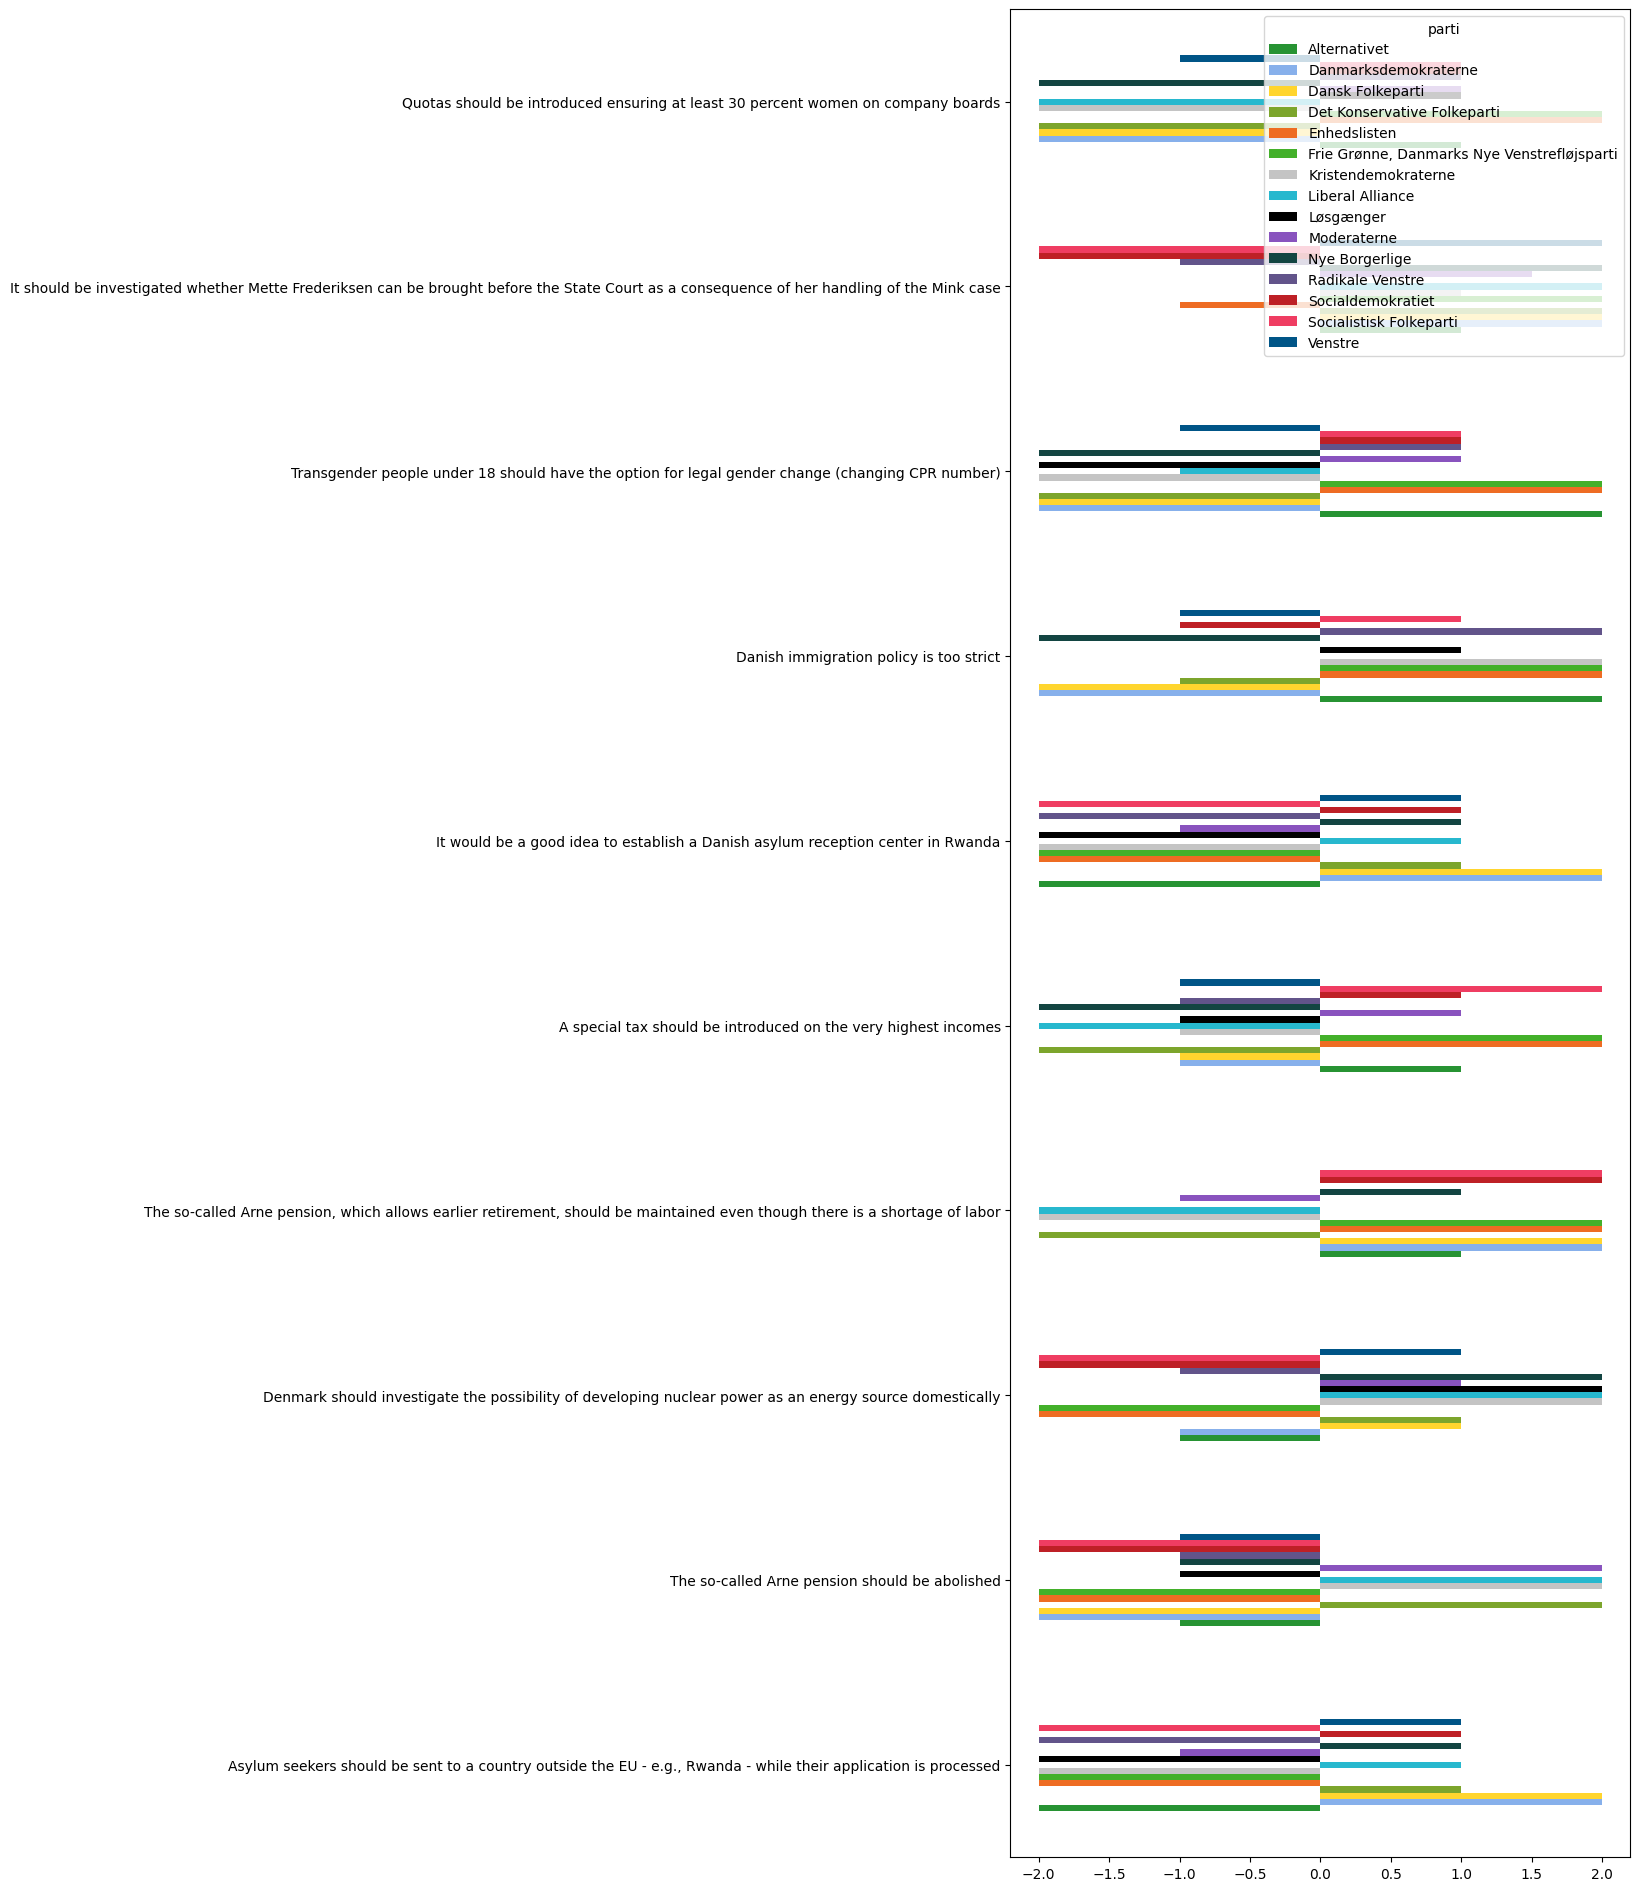

In [19]:
# using as little code as possible to plot party median for 10 most deciding questions (can be done much nicer by you!)
q_and_a[q_and_a_std.index].groupby(segments['parti']).median().T.iloc[:10].plot(kind='barh', figsize=(8, 24), colormap=cmap)
plt.show()

### 10. Cluster analysis of political parties

$$
\text{"Approach space":}
$$

$$
\begin{bmatrix}
\text{party-first} \\
\text{individual-first}
\end{bmatrix}
\times
\begin{bmatrix} 
\text{PCA} \\
\text{t-SNE} \\
\text{UMAP(?)} \\
\text{similarity-matrix}
\end{bmatrix} 
\times
\begin{bmatrix}
\text{cluster}\rightarrow\text{reduce} \\
\text{reduce}\rightarrow\text{cluster}
\end{bmatrix}
\times
\begin{bmatrix}
\text{k-means} \\
\text{hierarchical} \\
\text{DBSCAN}
\end{bmatrix}
\times

\begin{bmatrix}
k = 15-x \\
k = 15 \\
k = 15+x
\end{bmatrix}
$$

### 10a. PCA + Kmeans

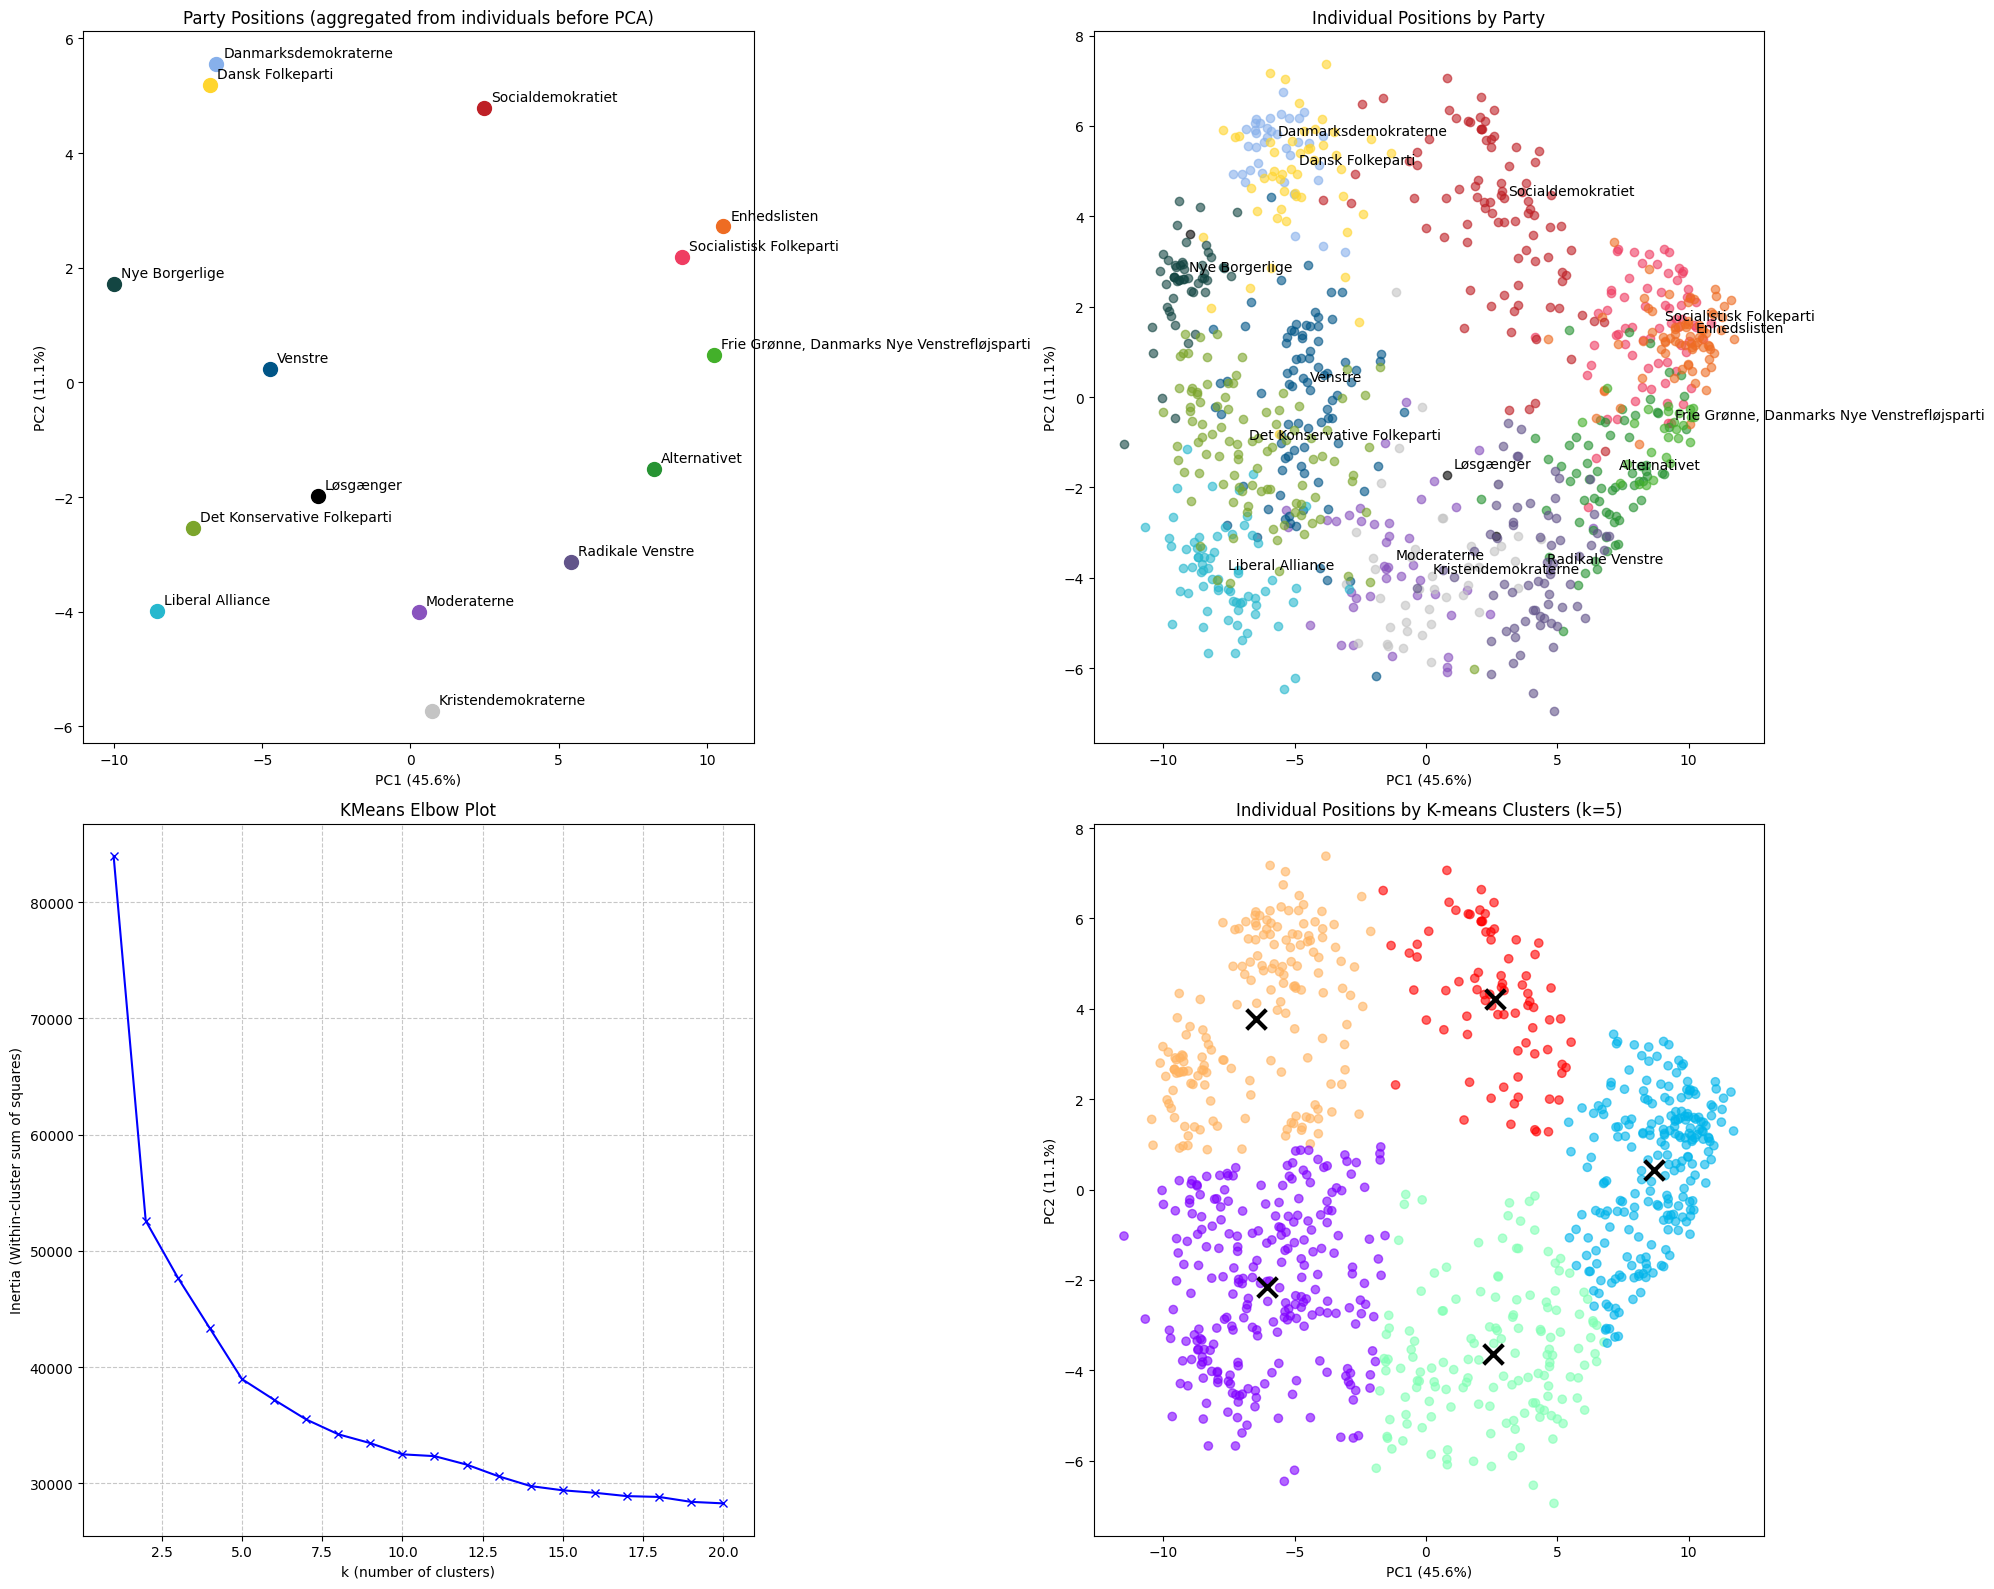

In [20]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# 2 x 2 plot
fig, axs = plt.subplots(2, 2, figsize=(20, 16))

# 1. party positions aggregated from individuals before PCA
party_positions = q_and_a.groupby(segments['parti']).median()
pca = PCA(n_components=2)
party_pca = pca.fit_transform(party_positions)

for i, party in enumerate(party_positions.index):
    axs[0,0].scatter(party_pca[i,0], party_pca[i,1], 
                     color=party_colors[party], s=100, label=party)
    axs[0,0].annotate(party, (party_pca[i,0], party_pca[i,1]), 
                      xytext=(5,5), textcoords='offset points')
axs[0,0].set_title('Party Positions (aggregated from individuals before PCA)')

# 2. individual positions by party
individual_pca = pca.fit_transform(q_and_a)
individual_pca[:, 1] *= -1 # inverting PC2 to more closely resemble aggregations before PCA
party_positions_after = pd.DataFrame(individual_pca, 
                                     columns=['PC1', 'PC2_inverse']).groupby(segments['parti']).median()

for party in segments['parti'].unique():
    mask = segments['parti'] == party
    axs[0,1].scatter(individual_pca[mask,0], individual_pca[mask,1], 
                     color=party_colors[party], alpha=0.6, label=party)
    axs[0,1].annotate(party, 
                      (party_positions_after.loc[party,'PC1'], 
                       party_positions_after.loc[party,'PC2_inverse']),
                      xytext=(5,5), textcoords='offset points')
axs[0,1].set_title('Individual Positions by Party')

# 3. KMeans elbow plot
inertias = []
K = range(1, 21)  # Testing k values from 1 to 20

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(q_and_a)
    inertias.append(kmeans.inertia_)

# plot inertia values
axs[1,0].plot(K, inertias, 'bx-')
axs[1,0].set_xlabel('k (number of clusters)')
axs[1,0].set_ylabel('Inertia (Within-cluster sum of squares)')
axs[1,0].set_title('KMeans Elbow Plot')

# Add grid for better readability
axs[1,0].grid(True, linestyle='--', alpha=0.7)

# 4. individual positions by k-means
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(individual_pca)
scatter = axs[1,1].scatter(individual_pca[:,0], individual_pca[:,1], 
                          c=clusters, cmap='rainbow', alpha=0.6)
axs[1,1].scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], 
                 color='black', marker='x', s=200, linewidth=3)
axs[1,1].set_title('Individual Positions by K-means Clusters (k=5)')

# common labels and layout
for i, ax in enumerate(axs.flat):
    if i != 2:
        ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
        ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')

plt.tight_layout()
plt.show()

You could argue k=2 or k=5 is optimal - but is this hard fact or interpretation?

### 10b. t-SNE + DBSCAN

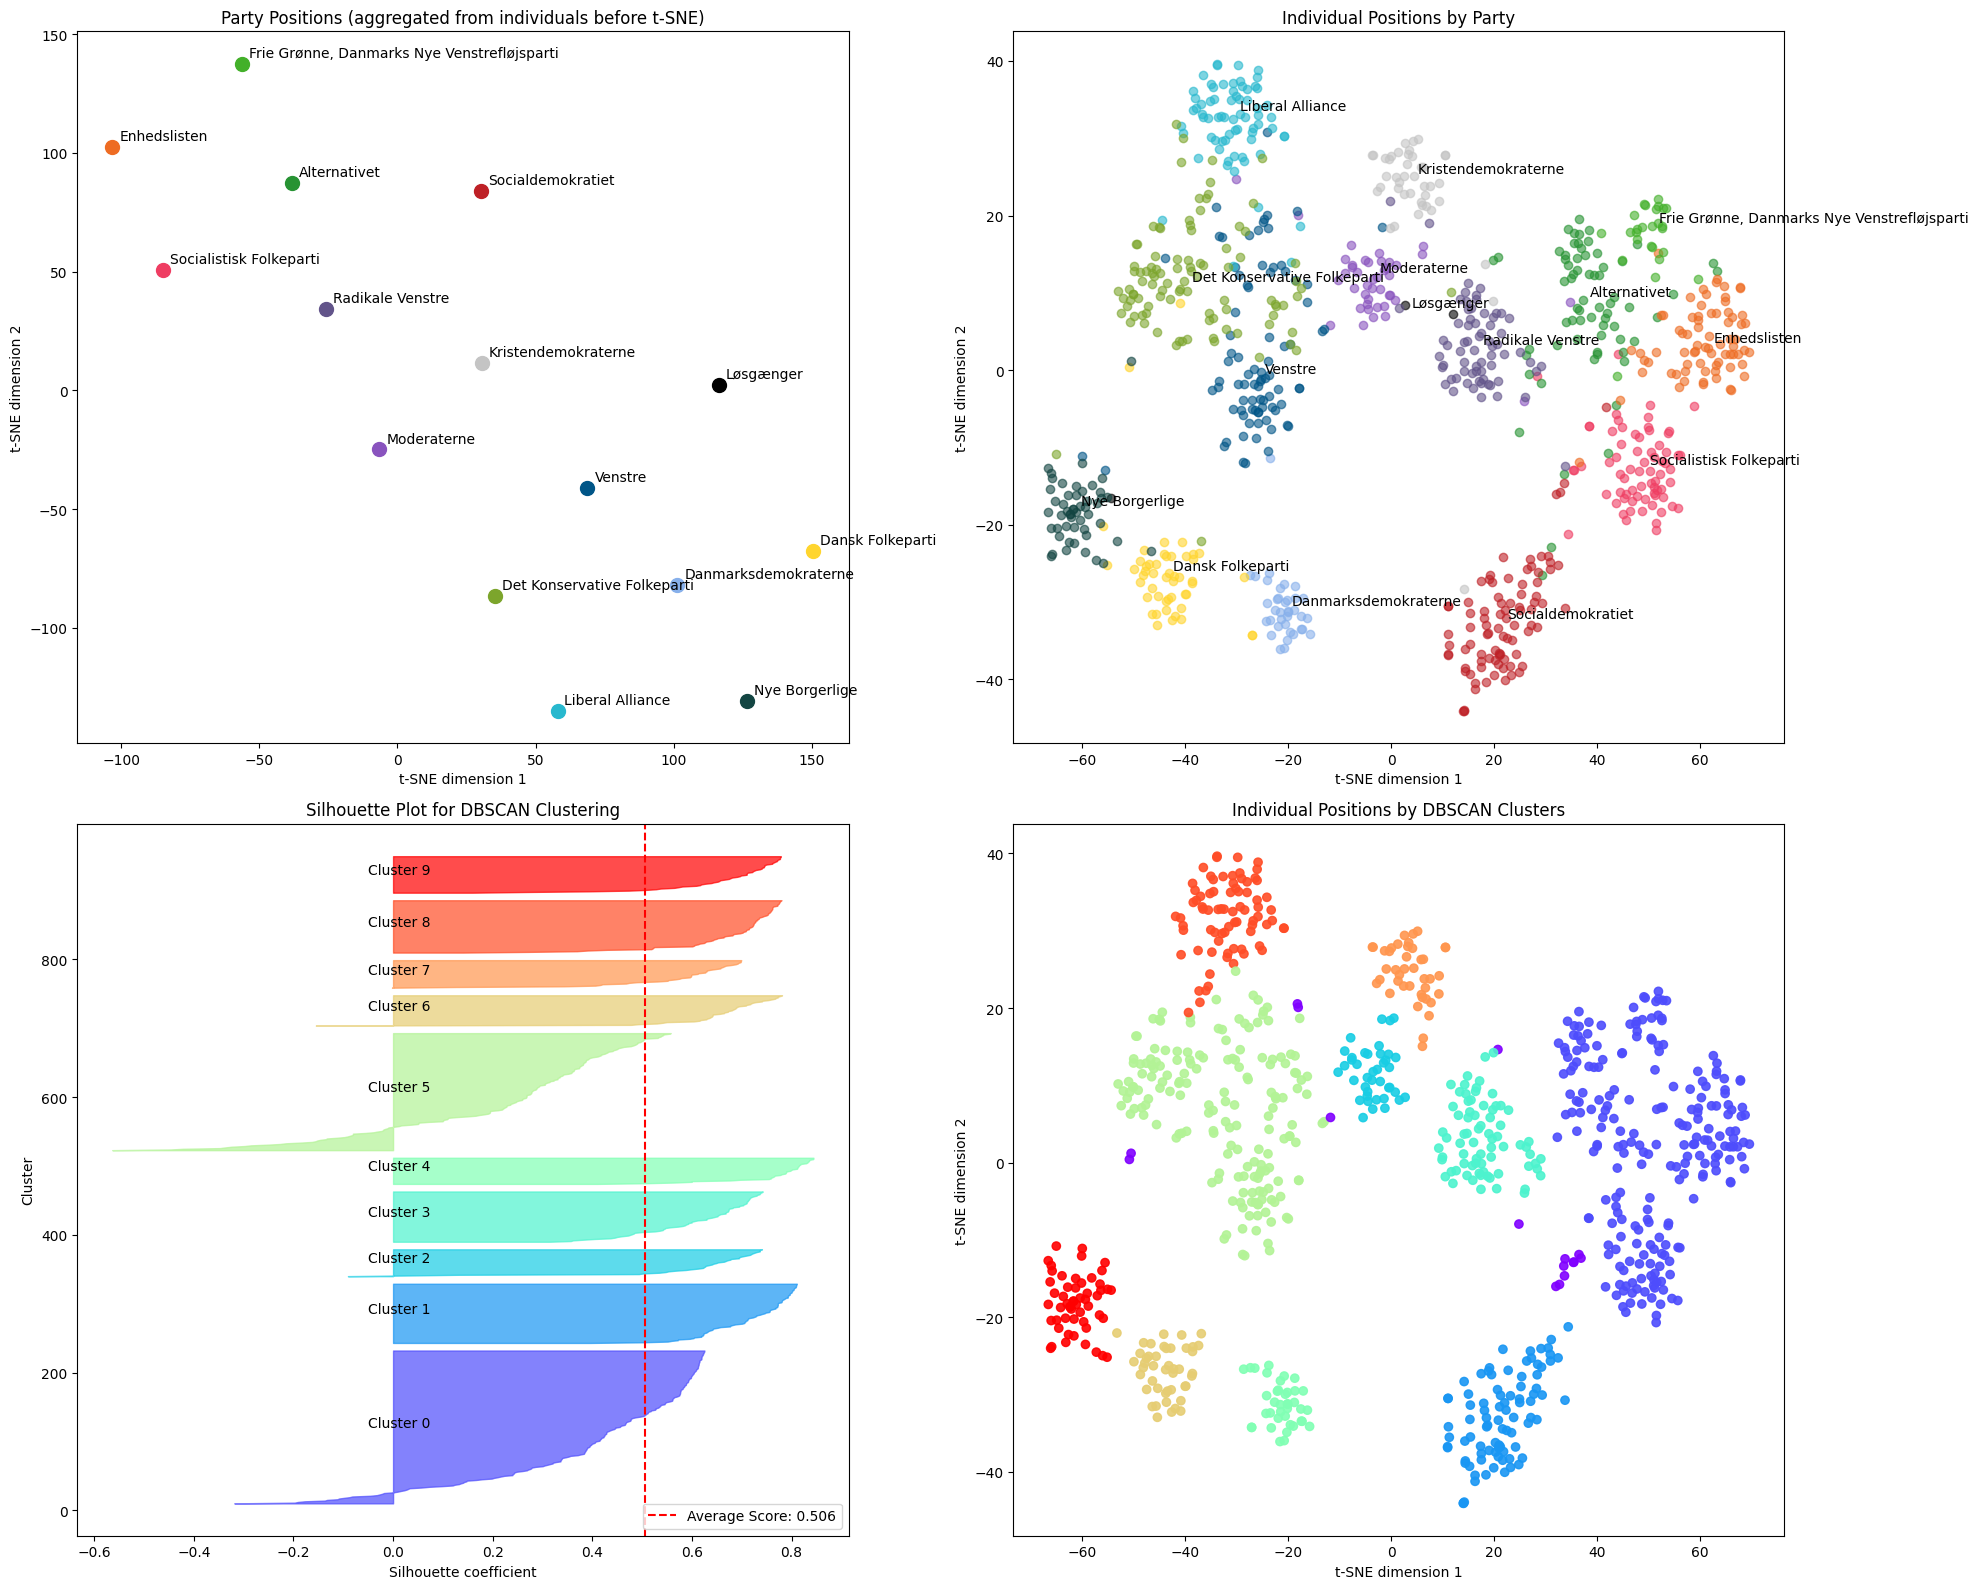

In [21]:
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score

# 2 x 2 plot
fig, axs = plt.subplots(2, 2, figsize=(20, 16))

# 1. party positions aggregated from individuals before t-SNE
party_positions = q_and_a.groupby(segments['parti']).median()
tsne = TSNE(n_components=2, random_state=7, perplexity=10)
party_tsne = tsne.fit_transform(party_positions)

for i, party in enumerate(party_positions.index):
    axs[0,0].scatter(party_tsne[i,0], party_tsne[i,1] * -1, 
                     color=party_colors[party], s=100, label=party)
    axs[0,0].annotate(party, (party_tsne[i,0], party_tsne[i,1] * -1), 
                      xytext=(5,5), textcoords='offset points')
axs[0,0].set_title('Party Positions (aggregated from individuals before t-SNE)')

# 2. individual positions by party
individual_tsne = tsne.fit_transform(q_and_a)

dbscan = DBSCAN(eps=5, min_samples=10)
clusters = dbscan.fit_predict(individual_tsne)

party_positions_after = pd.DataFrame(individual_tsne, 
                                   columns=['TSNE1', 'TSNE2']).groupby(segments['parti']).median()

for party in segments['parti'].unique():
    mask = segments['parti'] == party
    axs[0,1].scatter(individual_tsne[mask,0], individual_tsne[mask,1], 
                     color=party_colors[party], alpha=0.6, label=party)
    axs[0,1].annotate(party, 
                      (party_positions_after.loc[party,'TSNE1'], 
                       party_positions_after.loc[party,'TSNE2']),
                      xytext=(5,5), textcoords='offset points')
axs[0,1].set_title('Individual Positions by Party')

# 3. silhouette plot
mask = clusters != -1
silhouette_vals = silhouette_samples(individual_tsne[mask], clusters[mask])
silhouette_avg = silhouette_score(individual_tsne[mask], clusters[mask])

y_lower = 10
unique_clusters = np.unique(clusters[mask]) # keep original order

# get the same color mapping as used in the scatter plot
norm = plt.Normalize(vmin=min(clusters), vmax=max(clusters)) # use full clusters range, including -1
color_map = plt.cm.rainbow

for cluster in unique_clusters:
    cluster_silhouette_vals = silhouette_vals[clusters[mask] == cluster]
    cluster_silhouette_vals.sort()
    
    size_cluster = len(cluster_silhouette_vals)
    y_upper = y_lower + size_cluster
    
    color = color_map(norm(cluster))
    axs[1,0].fill_betweenx(np.arange(y_lower, y_upper),
                          0, cluster_silhouette_vals,
                          facecolor=color, edgecolor=color, alpha=0.7)
    
    # label the silhouette plots with cluster numbers
    axs[1,0].text(-0.05, y_lower + 0.5 * size_cluster, f'Cluster {cluster}')
    y_lower = y_upper + 10

axs[1,0].axvline(x=silhouette_avg, color="red", linestyle="--", 
                 label=f'Average Score: {silhouette_avg:.3f}')
axs[1,0].set_title('Silhouette Plot for DBSCAN Clustering')
axs[1,0].set_xlabel('Silhouette coefficient')
axs[1,0].set_ylabel('Cluster')
axs[1,0].legend(loc='lower right')

# 4. individual positions by DBSCAN
scatter = axs[1,1].scatter(individual_tsne[:,0], individual_tsne[:,1], 
                          c=clusters, cmap='rainbow', alpha=0.9)
axs[1,1].set_title('Individual Positions by DBSCAN Clusters')

# common labels and layout
for i, ax in enumerate(axs.flat):
    if i != 2:
        ax.set_xlabel('t-SNE dimension 1')
        ax.set_ylabel('t-SNE dimension 2')

plt.tight_layout()
plt.show()

### 10c. Correlation matrix + hierarchical (agglomerative, i.e. bottom-up)

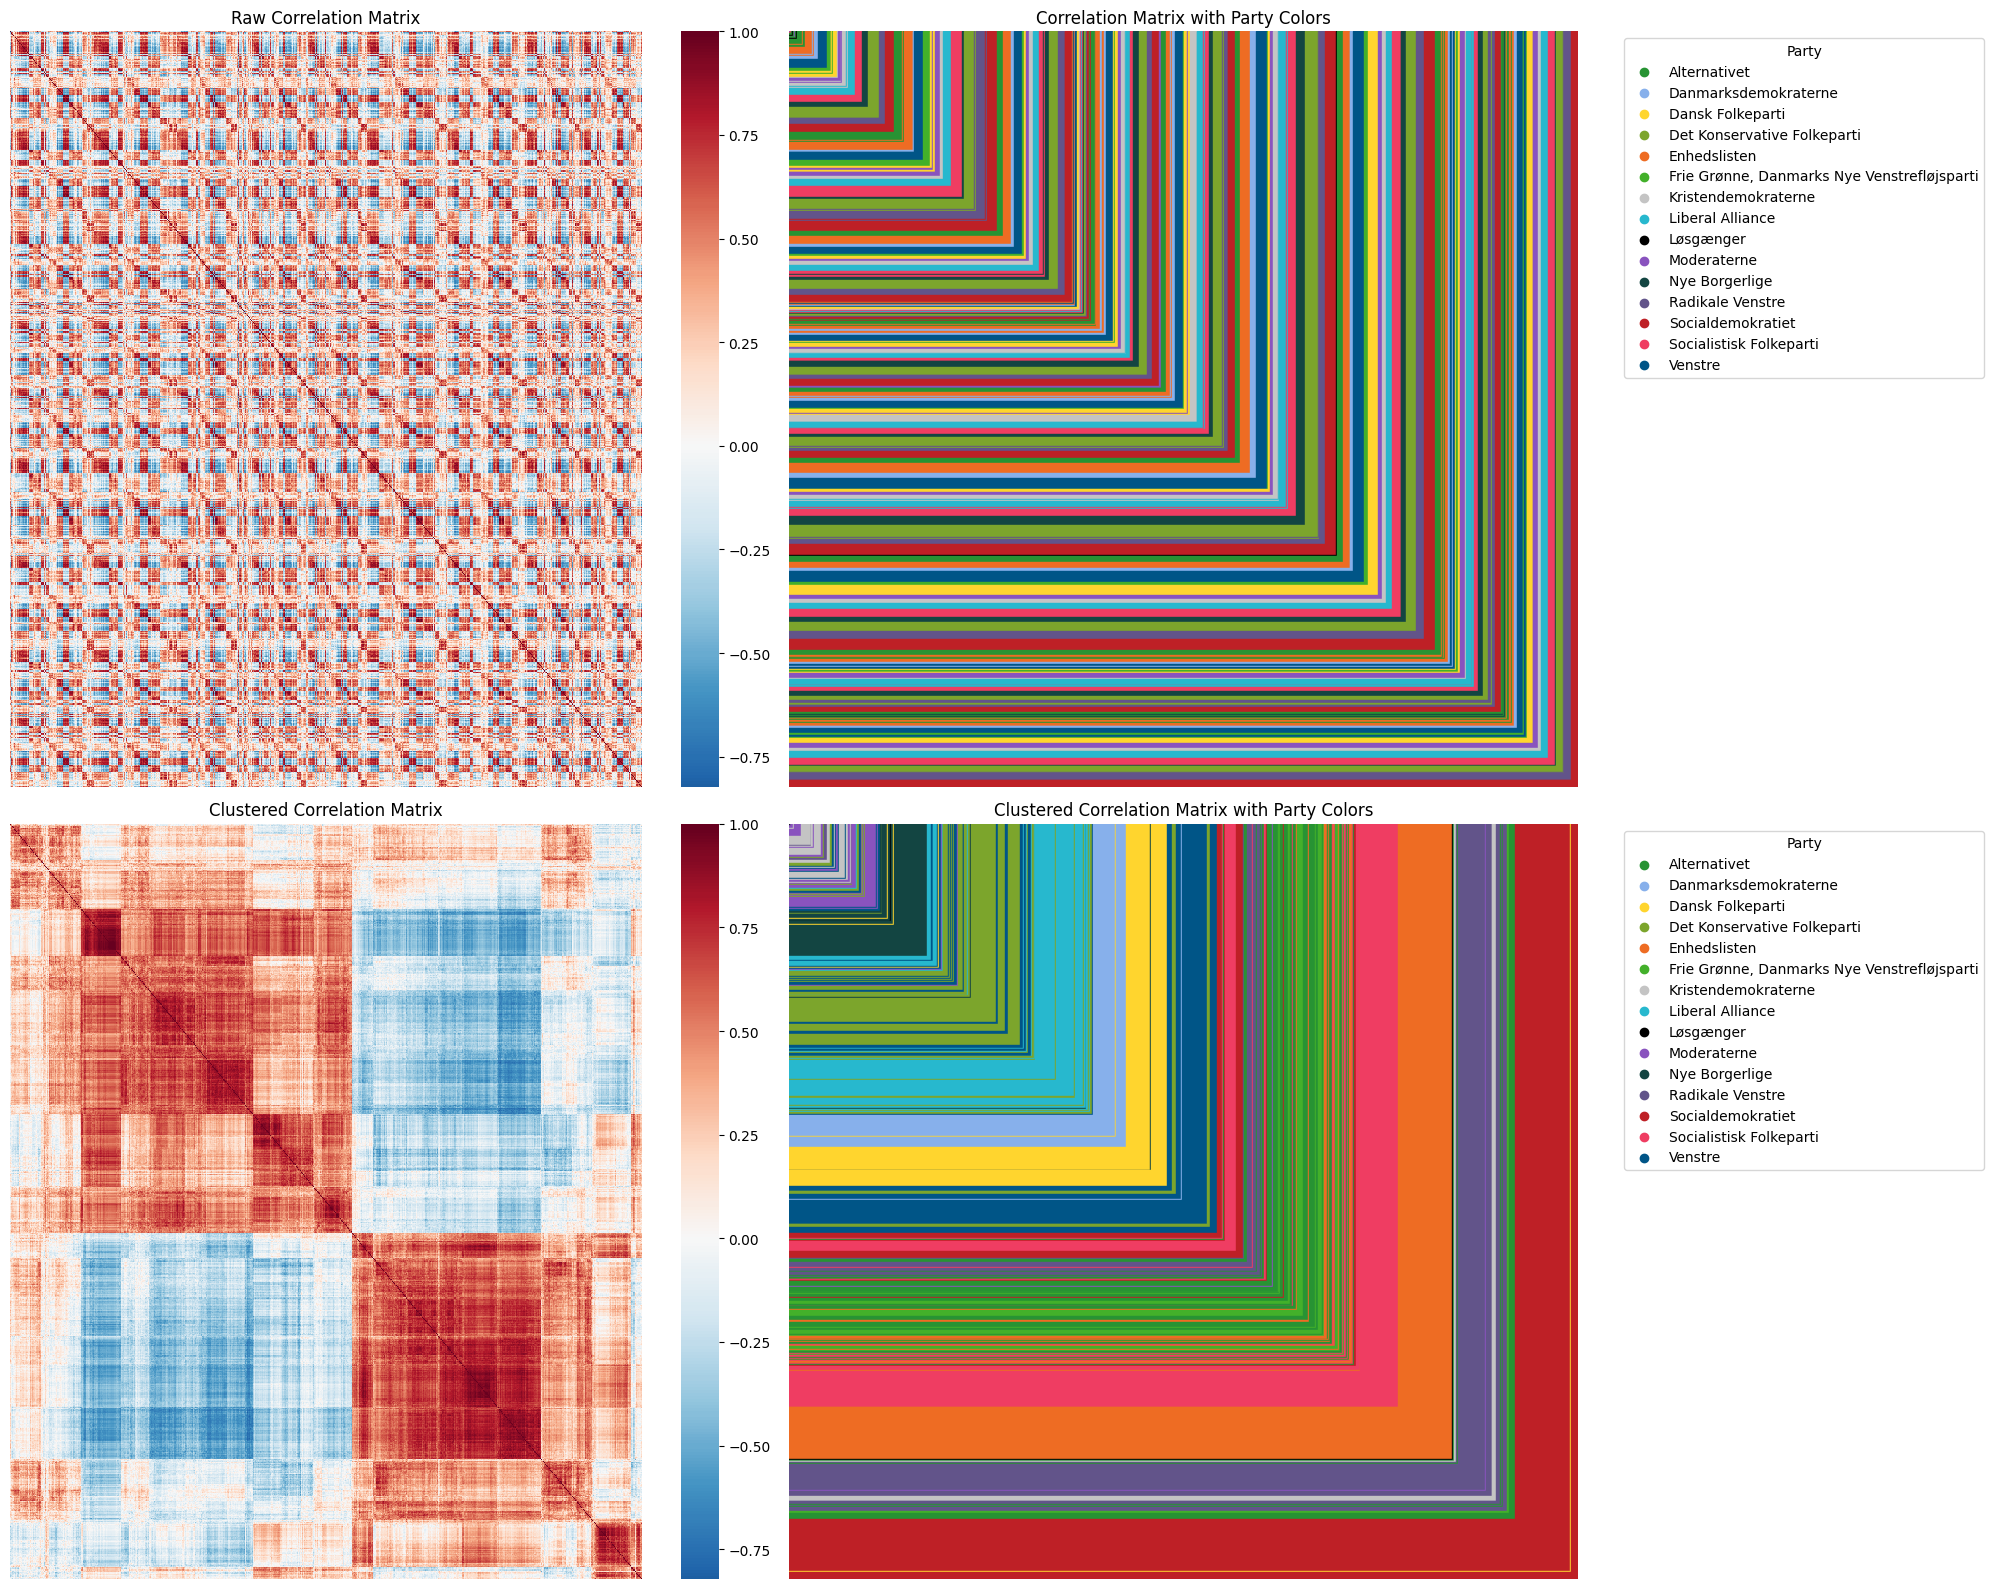

In [22]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

# 2 x 2 plot
fig, axs = plt.subplots(2, 2, figsize=(20, 16))

# correlations between politician's answers (notice .T)
corr = q_and_a.T.corr()

# euclidean distances between each answer using correlations as dimensions
dists = pdist(corr)

# cluster analysis using ward's linkage (measuring sum of squares of distances to center of new cluster - if merged/linked)
linkages = hierarchy.linkage(dists, method='average') # [ward, average, complete, etc.] ... experiment with different linkage methods

# get clustered indexes to create clustered correlations
idx = hierarchy.leaves_list(linkages)
corr_clustered = corr.iloc[idx, idx]

# 1. raw correlation heatmap (top-left)
sns.heatmap(corr, ax=axs[0,0], cmap='RdBu_r', center=0,
            xticklabels=False, yticklabels=False)
axs[0,0].set_title('Raw Correlation Matrix')

# 2. raw correlation with party colors (top-right)
sns.heatmap(corr, ax=axs[0,1], cmap='RdBu_r', center=0,
            xticklabels=False, yticklabels=False, cbar=False)
for c in party_colors.values():
    axs[0,1].scatter([-1000], [-1000], color=c) # single points outside area to help with legend
parties = segments['parti']
for i, party in enumerate(parties):
    axs[0,1].add_patch(plt.Rectangle((-0.5, i), corr.shape[0], 1, 
                       fill=True, color=party_colors[party], alpha=1))
    axs[0,1].add_patch(plt.Rectangle((i, -0.5), 1, corr.shape[0], 
                       fill=True, color=party_colors[party], alpha=1))
axs[0,1].legend(party_colors.keys(),
                bbox_to_anchor=(1.05, 1), 
                loc='upper left',
                title='Party')
axs[0,1].set_title('Correlation Matrix with Party Colors')

# 3. clustered correlation (bottom-left)
sns.heatmap(corr_clustered, ax=axs[1,0], cmap='RdBu_r', center=0,
            xticklabels=False, yticklabels=False)
axs[1,0].set_title('Clustered Correlation Matrix')

# 4. clustered correlation with party colors (bottom-right)
sns.heatmap(corr_clustered, ax=axs[1,1], cmap='RdBu_r', center=0,
            xticklabels=False, yticklabels=False, cbar=False)
for c in party_colors.values():
    axs[1,1].scatter([-1000], [-1000], color=c) # single points outside area to help with legend
parties_clustered = parties.iloc[idx]
for i, party in enumerate(parties_clustered):
    axs[1,1].add_patch(plt.Rectangle((-0.5, i), corr.shape[0], 1, 
                       fill=True, color=party_colors[party], alpha=1))
    axs[1,1].add_patch(plt.Rectangle((i, -0.5), 1, corr.shape[0], 
                       fill=True, color=party_colors[party], alpha=1))
axs[1,1].set_title('Clustered Correlation Matrix with Party Colors')
axs[1,1].legend(party_colors.keys(),
                bbox_to_anchor=(1.05, 1), 
                loc='upper left',
                title='Party')

plt.tight_layout()
plt.show()

Ideas:
* Experiment with different metrics (e.g. cosine similarity instead of correlation, Manhattan distance instead of Euclidean, Ward linkage instead of average, etc.)
* Add heatmap colored by cluster and compare to the one colored by party.
* Do the same analysis of questions instead of answers. Compare this to a PCA analysis of variance-normalized questions.

### 10c. (continued) Dendrogram

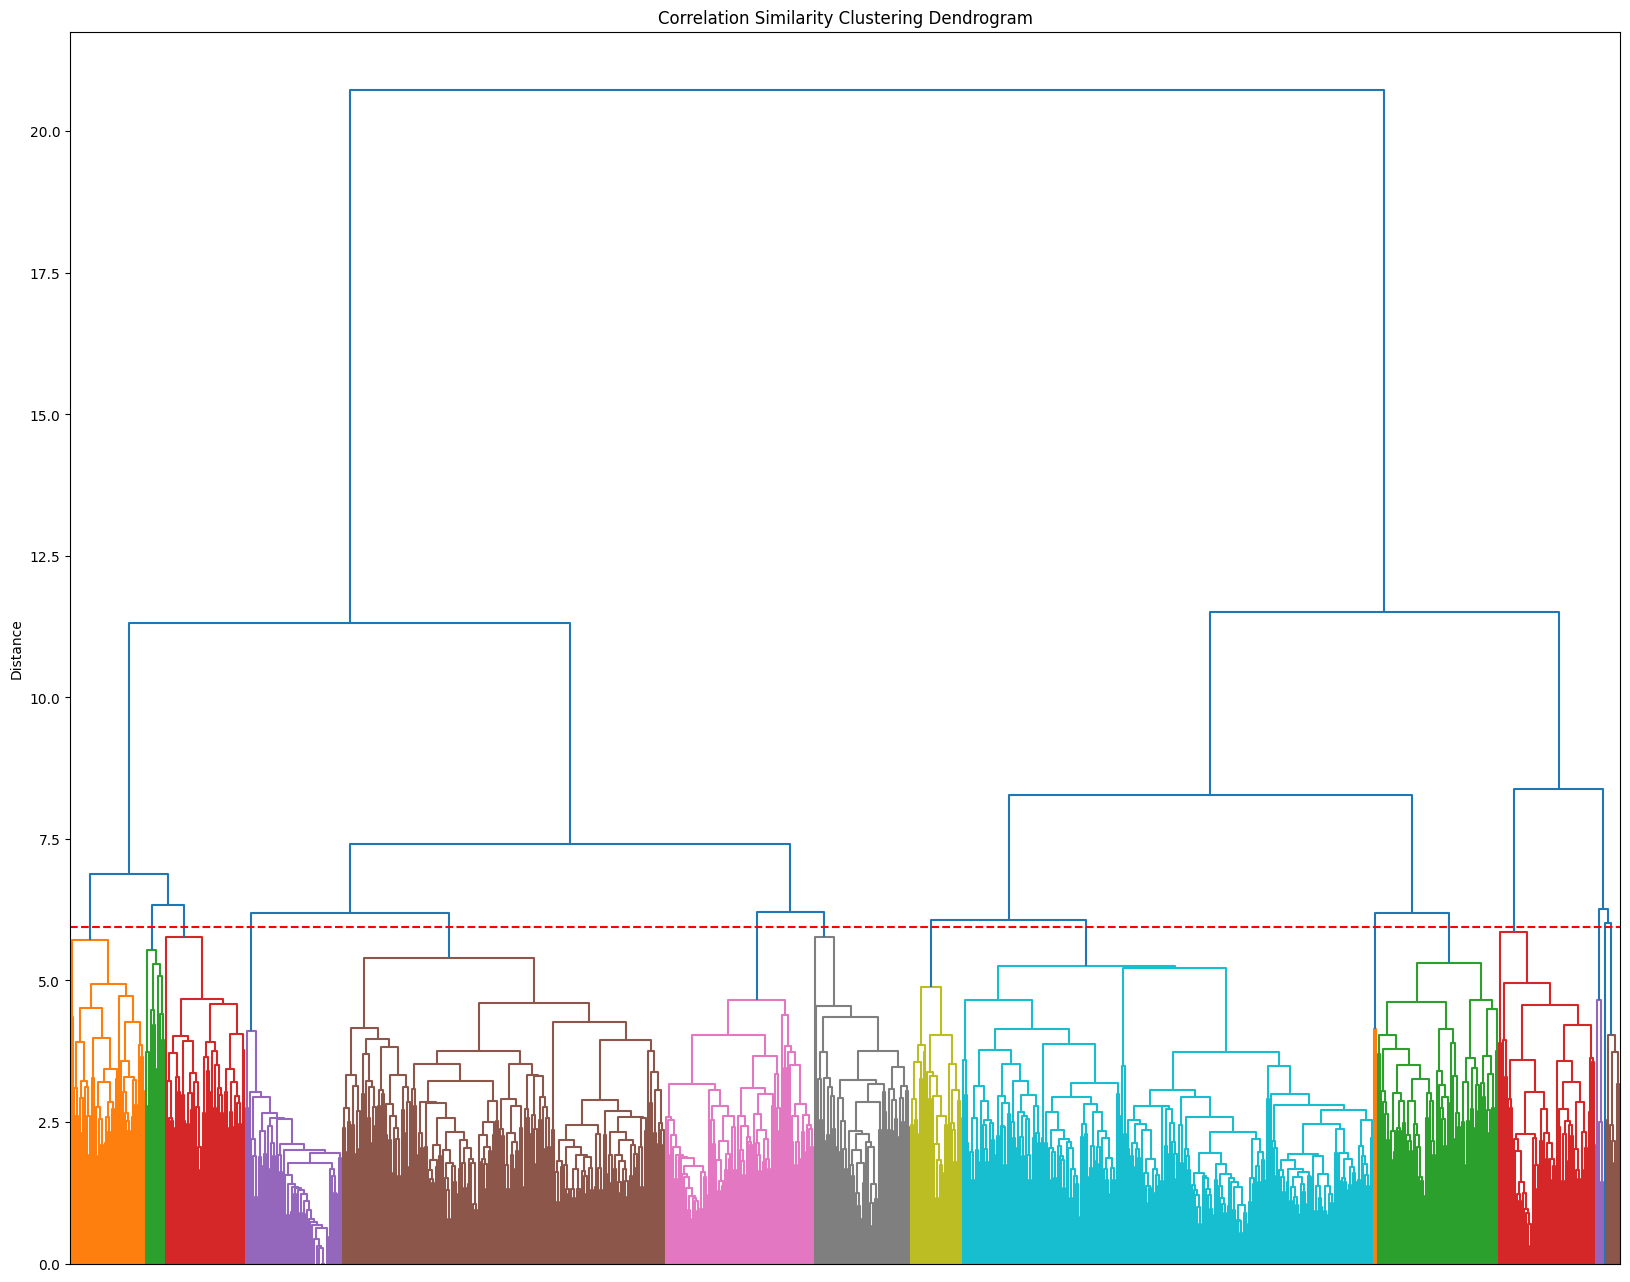

In [23]:
# 1 x 1 plot
plt.figure(figsize=(20, 16))

# get 15 cluster threshold (between two merge distances)
max_d = linkages[-15:-13, 2].mean()

# add dendrogram
hierarchy.dendrogram(
    linkages,
    color_threshold=max_d
)

# add line, title, etc
plt.axhline(y=max_d, color='r', linestyle='--')
plt.title('Correlation Similarity Clustering Dendrogram')
plt.ylabel('Distance')
plt.xticks([])

plt.show()

### Notes:

* In both the PCA/Kmeans and t-SNE/DBSCAN clustering cases, we clustered on the reduced dimensions. The original dimensions were 49 (number of questions) which we could have clustered on, but we chose to cluster on only the 2 visualized ones. The results could be very different.
* In the Correlation/Agglomerative (bottom-up hierarchical) case, we clustered on 49 transformed dimensions (correlation scores instead of actual response values).
* We did not investigate multicollinearity, although the PCA capturing >50% variance within the 2 first components suggests it is high.
* We did not try different combinations, we did not try UMAP